# CE-40959: Deep Learning
## HW5 - Generative Adversarial Networks
#### 32 Points | Deadline: 4th of Khordad

---

Name:
Seyed Shayan Nazemi

Student No.:
98209037

---

**!!! CAUTION !!!**

* Please **remove the in training generated images** when you want to upload your assignment; but **keep the "Final Visualization"** section outputs.

* To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.


More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)
```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}
setInterval(ClickConnect,60000)
```
---


In [0]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [11]:
!pip install gpustat

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm

%matplotlib inline

In [0]:
CUDA = True

device = torch.device("cuda:0" if CUDA else "cpu")

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Auxiliary Modules

In [0]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    if type(self.z_dim) == tuple:
        noise = torch.randn(n, *self.z_dim).to(device)
    else : 
        noise = torch.randn(n, self.z_dim).to(device)
    return noise

# 2) GAN Training Structure (14 points)

Complete the following class to define the GAN training structure.

In [0]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments: \n
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch. \n
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`. \n
  `generator`: The generator. \n
  `discriminator`: The discriminator. The last layer is a LINEAR layer. \n
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    self.opt_G = optim.Adam(generator.parameters(), lr=G_lr)
    self.opt_D = optim.Adam(discriminator.parameters(), lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = self.noise_generator(n)
    fake_samples = self.generator(noise)
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    _, x_fake = self.generate_samples(n)
    logits = self.discriminator(x_fake)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = F.binary_cross_entropy_with_logits(logits, torch.ones_like(logits))
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = -F.binary_cross_entropy_with_logits(logits, torch.zeros_like(logits))
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. What is the value of `n`? why?
    #  put them in `x_fake`
    # 2) Detach the generated samples. why?
    ####################################################
    
    x_fake = self.generate_samples(x_real.size(0))[1].detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################

    out_real = self.discriminator(x_real)
    out_fake = self.discriminator(x_fake)

    loss_real = F.binary_cross_entropy_with_logits(out_real, torch.ones_like(out_real))
    loss_fake = F.binary_cross_entropy_with_logits(out_fake, torch.zeros_like(out_fake))
    
    loss = loss_real + loss_fake
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times, verbose=True):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)

      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 3) Zero out `opt_D`'s gradients
        # 4) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 5) Backpropagate `D_loss`
        # 6) Update ``discriminator` parameters
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 3) Zero out `opt_G`'s gradients
        # 4) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 5) Backpropagate `G_loss`
        # 6) Update `generator` parameters
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        self.opt_G.zero_grad()
        G_loss, _ = self.G_step(x.shape[0])
        G_loss.backward()
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if verbose and batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    if verbose:
        print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self, verbose=True):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        G_loss, _ = self.G_step(x.shape[0])
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    if verbose:
      print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1, verbose=True):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    !gpustat
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times, verbose)
        self.test(verbose)
        self.visualization_helper_fn(self)
        if epoch == 1:
          !gpustat


---

# 3) Part 1 - 2D Toy Dataset

In the first part, we will learn density of toy datasets to examine GAN training.

## 3.1) Helper functions
These are functions used in visulization.

In [0]:
def toy2d_density_plot(samples, title, ax=None):
  """
  This function plots the distribution of `samples`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  sns.kdeplot(samples[:, 0], samples[:, 1], shade=True, ax=ax)
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [0]:
def toy2d_decision_boundary_plot(samples, labels, title, ax=None):
  """
  This function plots regions corresponding to each label value. Can be used to
  understand the decision boundary of `discriminator`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()

  sns.scatterplot(
      x=samples[:, 0],
      y=samples[:, 1],
      hue=labels,
      legend='brief',
      marker='.',
      ax=ax
      )
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [0]:
def toy2d_visulization_helper_fn(trainer: GANTrainer):
  """
  Used to visualize generator's distribution and 
  discriminator's decision boundary.
  """
  rows = 1
  cols = 2
  fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(3 * cols, 3 * rows))

  _, fake_samples = trainer.generate_samples(10000)
  random_samples = (torch.rand((10000, 2)) - .5) * 3 * R
  random_samples = random_samples.to(device)
  with torch.no_grad():
    disc_labels = torch.sigmoid(trainer.discriminator(random_samples))[:, 0]
  
  toy2d_density_plot(fake_samples, 'generator distribution', axs[0][0])
  toy2d_decision_boundary_plot(random_samples, disc_labels, 'discriminator decision boundary', axs[0][1])

  plt.show()

## 3.2) Defining Toy Datasets

In [0]:
class Toy2dCircularGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes` gaussians on a circle with 'r' radius.
  """
  def __init__(self, r=10, std_dev=1, n_modes=20, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples,))
    theta = 2 * np.pi / n_modes * self.mode_ids
    mu = self.r * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

In [0]:
class Toy2dGridGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes^2` gaussians on a grid with '2r' width and height.
  """
  def __init__(self, r=1, std_dev=1, n_modes=5, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    assert n_modes >= 2
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples, 2))
    mu = self.mode_ids * (2 * self.r / (self.n_modes - 1)) - self.r
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

## 3.3) Dataset Loading


You can load either `Toy2dCircularGaussiansDataset` or `Toy2dGridGaussiansDataset` to play with it; but the question at the end of this part is for the `Toy2dGridGaussiansDataset` dataset.

In [0]:
# parameters of toy dataset
TRAIN_SIZE = 60000
TEST_SIZE = 10000
R = 1

# ############### To use `Toy2dCircularGaussiansDataset` ############### #
# N_MODES = 8
# STD_DEV = 25e-3
# toy2d_train_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
# toy2d_test_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

# ################# To use `Toy2dGridGaussiansDataset` ################# #
N_MODES = 4
STD_DEV = 1e-4
toy2d_train_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
toy2d_test_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

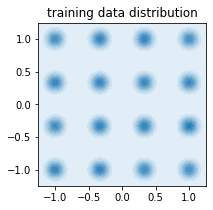

In [35]:
# Ploting dataset distribution to see it :)

toy2d_density_plot(toy2d_train_dataset[:10000][0], 'training data distribution')

## 3.4) Defining Models (4 points)

In [36]:
# Generator part
#################### Problem 12 (2 points) ####################
# 1) Define `toy2d_noise_generator`.
# 2) Define `toy2d_generator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer.
####################################################

z_dim = 256
toy2d_noise_generator = NoiseGenerator(z_dim)

toy2d_generator = nn.Sequential(
    nn.Linear(z_dim, 64),
    nn.Tanh(),
    nn.Linear(64, 32),
    nn.Tanh(),
    nn.Linear(32, 16),
    nn.Tanh(),
    nn.Linear(16, 2)
)
####################### End ########################

# Discriminator part
#################### Problem 13 (2 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer. why?
####################################################
toy2d_discriminator = nn.Sequential(
    nn.Linear(2, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 2)
)
####################### End ########################

toy2d_generator = toy2d_generator.to(device)
toy2d_discriminator = toy2d_discriminator.to(device)

print(toy2d_generator)
print(toy2d_discriminator)

Sequential(
  (0): Linear(in_features=256, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=2, bias=True)
)


## 3.5) Train

### 3.5.1) Batching Data

In [0]:
BATCH_SIZE = 1024

toy2d_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

toy2d_train_dataloader = torch.utils.data.DataLoader(toy2d_train_dataset, **toy2d_dataloader_kwargs)
toy2d_test_dataloader = torch.utils.data.DataLoader(toy2d_test_dataset, **toy2d_dataloader_kwargs)

### 3.5.2) Run (2 points)

In [0]:
LOG_INTERVAL = 50
#################### Problem 14 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
TOY2D_G_LEARNING_RATE = 1e-4
TOY2D_D_LEARNING_RATE = 1e-4
G_LOSS_MODE = 'logD'
####################### End ########################

toy2d_trainer = GANTrainer(toy2d_train_dataloader, toy2d_test_dataloader,
                           toy2d_noise_generator, toy2d_generator, toy2d_discriminator,
                           TOY2D_G_LEARNING_RATE, TOY2D_D_LEARNING_RATE,
                           toy2d_visulization_helper_fn, G_LOSS_MODE)

b0f63c750b34             Sun May 24 14:32:34 2020  418.67
[0] Tesla P100-PCIE-16GB | 36'C,   0 % |   713 / 16280 MB |


Train | Epoch: 1 [0/60416]		D-Loss: 1.391678	G-Loss: 0.612828
Train | Epoch: 1 [51200/60416]		D-Loss: 1.385327	G-Loss: 0.636192

====> Train | Epoch: 1 	 | 	Average D-loss: 1.3786 	 | 	Average G-loss: 0.6221
====> Test | Average D-loss: 1.3533 	 | 	Average G-loss: 0.6243


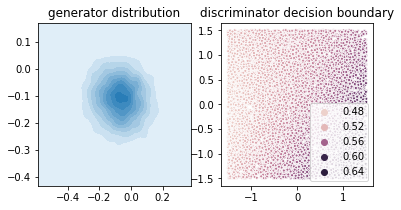

b0f63c750b34             Sun May 24 14:32:43 2020  418.67
[0] Tesla P100-PCIE-16GB | 36'C,   0 % |   735 / 16280 MB |


Train | Epoch: 2 [0/60416]		D-Loss: 1.387277	G-Loss: 0.639662
Train | Epoch: 2 [51200/60416]		D-Loss: 1.386100	G-Loss: 0.656395

====> Train | Epoch: 2 	 | 	Average D-loss: 1.3765 	 | 	Average G-loss: 0.6450
====> Test | Average D-loss: 1.3535 	 | 	Average G-loss: 0.6424


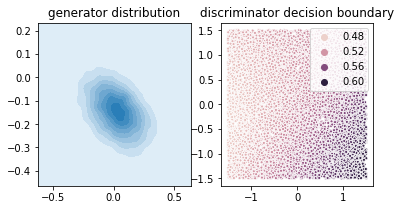

Train | Epoch: 3 [0/60416]		D-Loss: 1.385743	G-Loss: 0.657910
Train | Epoch: 3 [51200/60416]		D-Loss: 1.386745	G-Loss: 0.667357

====> Train | Epoch: 3 	 | 	Average D-loss: 1.3774 	 | 	Average G-loss: 0.6592
====> Test | Average D-loss: 1.3545 	 | 	Average G-loss: 0.6528


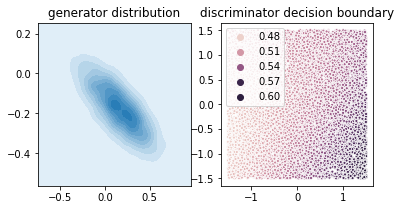

Train | Epoch: 4 [0/60416]		D-Loss: 1.387788	G-Loss: 0.668863
Train | Epoch: 4 [51200/60416]		D-Loss: 1.386364	G-Loss: 0.674411

====> Train | Epoch: 4 	 | 	Average D-loss: 1.3770 	 | 	Average G-loss: 0.6674
====> Test | Average D-loss: 1.3523 	 | 	Average G-loss: 0.6593


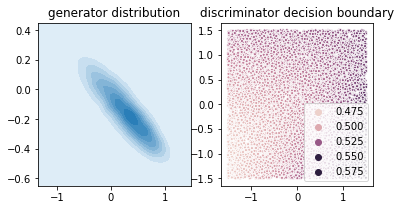

Train | Epoch: 5 [0/60416]		D-Loss: 1.385016	G-Loss: 0.675330
Train | Epoch: 5 [51200/60416]		D-Loss: 1.382254	G-Loss: 0.679768

====> Train | Epoch: 5 	 | 	Average D-loss: 1.3737 	 | 	Average G-loss: 0.6732
====> Test | Average D-loss: 1.3496 	 | 	Average G-loss: 0.6641


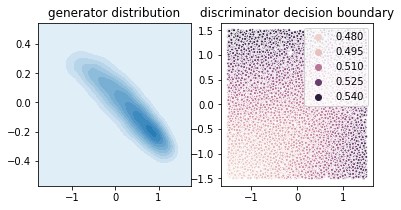

Train | Epoch: 6 [0/60416]		D-Loss: 1.381501	G-Loss: 0.680518
Train | Epoch: 6 [51200/60416]		D-Loss: 1.382808	G-Loss: 0.684516

====> Train | Epoch: 6 	 | 	Average D-loss: 1.3728 	 | 	Average G-loss: 0.6780
====> Test | Average D-loss: 1.3506 	 | 	Average G-loss: 0.6695


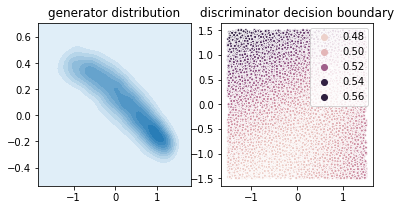

Train | Epoch: 7 [0/60416]		D-Loss: 1.381159	G-Loss: 0.684863
Train | Epoch: 7 [51200/60416]		D-Loss: 1.385990	G-Loss: 0.691507

====> Train | Epoch: 7 	 | 	Average D-loss: 1.3751 	 | 	Average G-loss: 0.6840
====> Test | Average D-loss: 1.3544 	 | 	Average G-loss: 0.6754


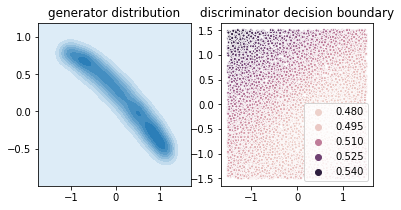

Train | Epoch: 8 [0/60416]		D-Loss: 1.386926	G-Loss: 0.693040
Train | Epoch: 8 [51200/60416]		D-Loss: 1.390742	G-Loss: 0.690042

====> Train | Epoch: 8 	 | 	Average D-loss: 1.3794 	 | 	Average G-loss: 0.6870
====> Test | Average D-loss: 1.3598 	 | 	Average G-loss: 0.6729


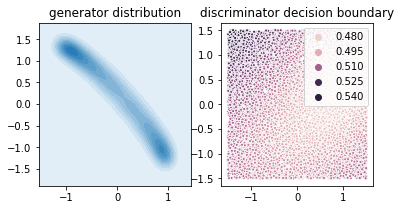

Train | Epoch: 9 [0/60416]		D-Loss: 1.392025	G-Loss: 0.688685
Train | Epoch: 9 [51200/60416]		D-Loss: 1.395594	G-Loss: 0.681836

====> Train | Epoch: 9 	 | 	Average D-loss: 1.3854 	 | 	Average G-loss: 0.6799
====> Test | Average D-loss: 1.3645 	 | 	Average G-loss: 0.6643


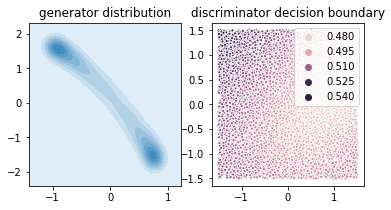

Train | Epoch: 10 [0/60416]		D-Loss: 1.396743	G-Loss: 0.679201
Train | Epoch: 10 [51200/60416]		D-Loss: 1.397547	G-Loss: 0.676188

====> Train | Epoch: 10 	 | 	Average D-loss: 1.3873 	 | 	Average G-loss: 0.6730
====> Test | Average D-loss: 1.3637 	 | 	Average G-loss: 0.6597


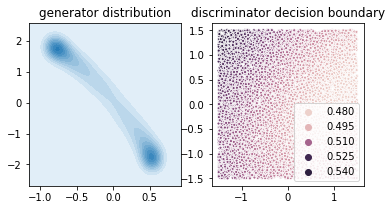

In [39]:
#################### Problem 15 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
toy2d_trainer.run(n_epoch=10, G_update_times=1, D_update_times=1, verbose=True)
####################### End ########################

### 3.5.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 12 to 15)

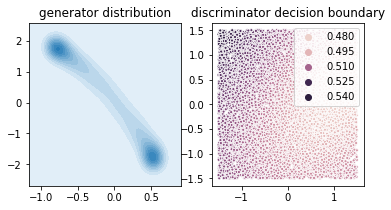

In [40]:
toy2d_visulization_helper_fn(toy2d_trainer)

## 3.6) Question (4 points)
Train GAN on `Toy2dGridGaussiansDataset` dataset for ENOUGH epochs.
We hope that our desired problem has occured for your model :)

Is the generator successful to learn the entire target distribution?
* (3 points) Define the *\"Mode Collapse\"* problem of GANs.
* (1 points) Why do you think this problem happens?

<div dir="rtl"> 
‫‫به این مشکل چسبیدگی به قله گفته میشود.
</div>

<div dir="rtl"> 
<b>
جواب شما
</b>


</div>

# 4) Part 2 - MNIST

In the second part, we will learn to generate MNIST like samples.

## 4.1) Helper functions
These are functions used in visulization.

In [0]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result

In [0]:
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows) # set default size of plots  TODO float(folan)?
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

In [0]:
def mnist_visulization_helper_fn(trainer: GANTrainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

In [0]:
def show_interpolations(trainer:GANTrainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

## 4.2) Dataset Loading

In [45]:
# Get MNIST dataloader

mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1, # to make pixel values between [-1, 1]
                                    #  lambda img: torch.transpose(img, 1, 2)
                                     ])
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)

print(len(mnist_train_dataset))

60000


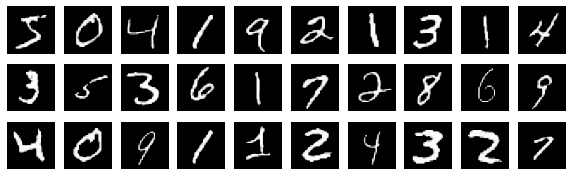

In [46]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

## 4.3) Defining Models (6 points)

In [47]:
# Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################

z_dim_mnist = (1, 34, 34)
mnist_noise_generator = NoiseGenerator(z_dim_mnist)

mnist_generator = nn.Sequential(
    nn.Conv2d(1, 4, (3, 3)),
    nn.BatchNorm2d(4),
    nn.LeakyReLU(0.1),
    nn.Conv2d(4, 8, (3, 3)),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.1),
    nn.Conv2d(8, 1, (3, 3)),
    nn.BatchNorm2d(1),
    nn.Tanh(),
    
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `mnist_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer. why?
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_discriminator = nn.Sequential(
    nn.Conv2d(1, 4, (3, 3), stride=2),
    nn.BatchNorm2d(4),
    nn.LeakyReLU(0.1),
    nn.Conv2d(4, 8, (3, 3), stride=2),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.1),
    nn.Flatten(),
    nn.Linear(288, 2)
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
)
Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Flatten()
  (7): Linear(in_features=288, out_features=2, bias=True)
)


## 4.4) Train

### 4.4.1) Batching Data

you can use `train_sampler` and `test_sampler` to test your model on smaller subset of dataset; but, the final report must be on the whole dataset.

In [0]:
BATCH_SIZE = 256

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 4,
}

# ############### To use complete dataset ############### #
train_sampler = None
test_sampler = None
mnist_dataloader_kwargs['shuffle'] = True
# ####################################################### #

# ############### To use subsample of dataset ############### #
# train_sampler = torch.utils.data.RandomSampler(mnist_train_dataset, replacement=True, num_samples=10000)
# test_sampler = torch.utils.data.RandomSampler(mnist_test_dataset, replacement=True, num_samples=2000)
# mnist_dataloader_kwargs['shuffle'] = False
# ########################################################### #

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler=train_sampler, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler=test_sampler, **mnist_dataloader_kwargs)

### 4.4.2) Run (2 points)

In [0]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 1e-5
MNIST_D_LEARNING_RATE = 1e-5
G_LOSS_MODE = 'logD'
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

b0f63c750b34             Sun May 24 14:37:46 2020  418.67
[0] Tesla P100-PCIE-16GB | 36'C,   0 % |   735 / 16280 MB |


Train | Epoch: 1 [0/60160]		D-Loss: 1.339311	G-Loss: 0.695988
Train | Epoch: 1 [12800/60160]		D-Loss: 1.344082	G-Loss: 0.644144
Train | Epoch: 1 [25600/60160]		D-Loss: 1.321650	G-Loss: 0.654036
Train | Epoch: 1 [38400/60160]		D-Loss: 1.311946	G-Loss: 0.668532
Train | Epoch: 1 [51200/60160]		D-Loss: 1.272203	G-Loss: 0.669058

====> Train | Epoch: 1 	 | 	Average D-loss: 1.3070 	 | 	Average G-loss: 0.6591
====> Test | Average D-loss: 1.2350 	 | 	Average G-loss: 0.6621


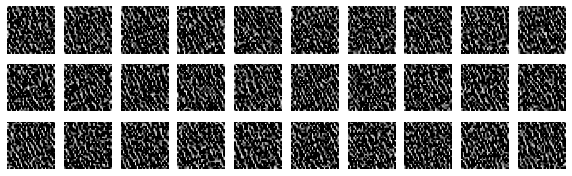

b0f63c750b34             Sun May 24 14:38:01 2020  418.67
[0] Tesla P100-PCIE-16GB | 36'C,   0 % |   783 / 16280 MB |


Train | Epoch: 2 [0/60160]		D-Loss: 1.263799	G-Loss: 0.683033
Train | Epoch: 2 [12800/60160]		D-Loss: 1.246677	G-Loss: 0.695226
Train | Epoch: 2 [25600/60160]		D-Loss: 1.238209	G-Loss: 0.694977
Train | Epoch: 2 [38400/60160]		D-Loss: 1.214436	G-Loss: 0.696662
Train | Epoch: 2 [51200/60160]		D-Loss: 1.187505	G-Loss: 0.702436

====> Train | Epoch: 2 	 | 	Average D-loss: 1.2266 	 | 	Average G-loss: 0.6934
====> Test | Average D-loss: 1.1575 	 | 	Average G-loss: 0.6957


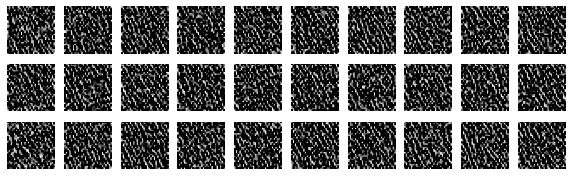

Train | Epoch: 3 [0/60160]		D-Loss: 1.195221	G-Loss: 0.724147
Train | Epoch: 3 [12800/60160]		D-Loss: 1.175917	G-Loss: 0.715911
Train | Epoch: 3 [25600/60160]		D-Loss: 1.160497	G-Loss: 0.738623
Train | Epoch: 3 [38400/60160]		D-Loss: 1.117990	G-Loss: 0.740044
Train | Epoch: 3 [51200/60160]		D-Loss: 1.113395	G-Loss: 0.747921

====> Train | Epoch: 3 	 | 	Average D-loss: 1.1433 	 | 	Average G-loss: 0.7310
====> Test | Average D-loss: 1.0772 	 | 	Average G-loss: 0.7326


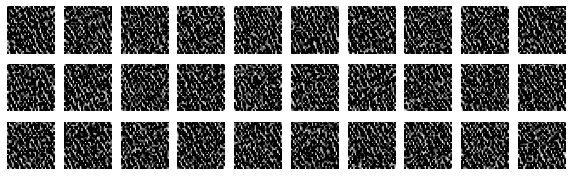

Train | Epoch: 4 [0/60160]		D-Loss: 1.110766	G-Loss: 0.752923
Train | Epoch: 4 [12800/60160]		D-Loss: 1.085413	G-Loss: 0.759345
Train | Epoch: 4 [25600/60160]		D-Loss: 1.059077	G-Loss: 0.785546
Train | Epoch: 4 [38400/60160]		D-Loss: 1.051981	G-Loss: 0.782061
Train | Epoch: 4 [51200/60160]		D-Loss: 1.012090	G-Loss: 0.788088

====> Train | Epoch: 4 	 | 	Average D-loss: 1.0585 	 | 	Average G-loss: 0.7737
====> Test | Average D-loss: 0.9875 	 | 	Average G-loss: 0.7782


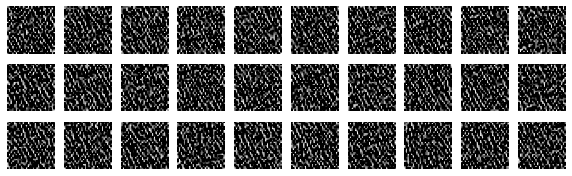

Train | Epoch: 5 [0/60160]		D-Loss: 1.011967	G-Loss: 0.812636
Train | Epoch: 5 [12800/60160]		D-Loss: 0.989831	G-Loss: 0.812450
Train | Epoch: 5 [25600/60160]		D-Loss: 0.973510	G-Loss: 0.823470
Train | Epoch: 5 [38400/60160]		D-Loss: 0.960465	G-Loss: 0.842343
Train | Epoch: 5 [51200/60160]		D-Loss: 0.937955	G-Loss: 0.841150

====> Train | Epoch: 5 	 | 	Average D-loss: 0.9723 	 | 	Average G-loss: 0.8278
====> Test | Average D-loss: 0.9096 	 | 	Average G-loss: 0.8347


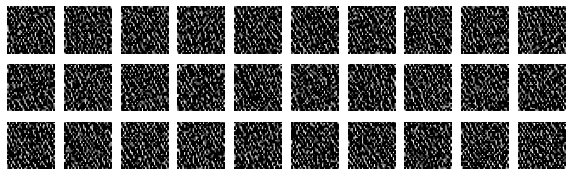

Train | Epoch: 6 [0/60160]		D-Loss: 0.953583	G-Loss: 0.862988
Train | Epoch: 6 [12800/60160]		D-Loss: 0.906133	G-Loss: 0.866451
Train | Epoch: 6 [25600/60160]		D-Loss: 0.905911	G-Loss: 0.900720
Train | Epoch: 6 [38400/60160]		D-Loss: 0.905124	G-Loss: 0.891796
Train | Epoch: 6 [51200/60160]		D-Loss: 0.873366	G-Loss: 0.905842

====> Train | Epoch: 6 	 | 	Average D-loss: 0.8987 	 | 	Average G-loss: 0.8830
====> Test | Average D-loss: 0.8368 	 | 	Average G-loss: 0.8915


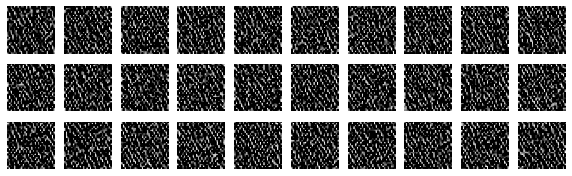

Train | Epoch: 7 [0/60160]		D-Loss: 0.861529	G-Loss: 0.919117
Train | Epoch: 7 [12800/60160]		D-Loss: 0.851568	G-Loss: 0.917898
Train | Epoch: 7 [25600/60160]		D-Loss: 0.828612	G-Loss: 0.908081
Train | Epoch: 7 [38400/60160]		D-Loss: 0.836179	G-Loss: 0.938822
Train | Epoch: 7 [51200/60160]		D-Loss: 0.801272	G-Loss: 0.968697

====> Train | Epoch: 7 	 | 	Average D-loss: 0.8303 	 | 	Average G-loss: 0.9403
====> Test | Average D-loss: 0.7749 	 | 	Average G-loss: 0.9492


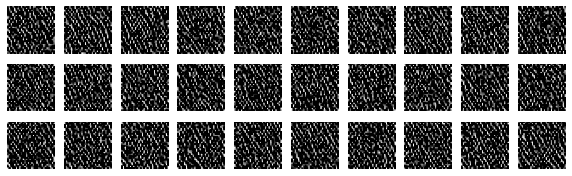

Train | Epoch: 8 [0/60160]		D-Loss: 0.808161	G-Loss: 0.976264
Train | Epoch: 8 [12800/60160]		D-Loss: 0.803511	G-Loss: 1.005820
Train | Epoch: 8 [25600/60160]		D-Loss: 0.788380	G-Loss: 0.987710
Train | Epoch: 8 [38400/60160]		D-Loss: 0.769535	G-Loss: 1.025085
Train | Epoch: 8 [51200/60160]		D-Loss: 0.759160	G-Loss: 1.040723

====> Train | Epoch: 8 	 | 	Average D-loss: 0.7686 	 | 	Average G-loss: 1.0010
====> Test | Average D-loss: 0.7161 	 | 	Average G-loss: 1.0099


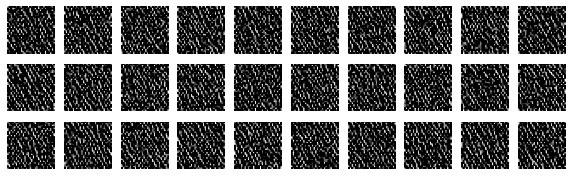

Train | Epoch: 9 [0/60160]		D-Loss: 0.737109	G-Loss: 1.033520
Train | Epoch: 9 [12800/60160]		D-Loss: 0.705379	G-Loss: 1.024503
Train | Epoch: 9 [25600/60160]		D-Loss: 0.725148	G-Loss: 1.059625
Train | Epoch: 9 [38400/60160]		D-Loss: 0.717087	G-Loss: 1.083013
Train | Epoch: 9 [51200/60160]		D-Loss: 0.678407	G-Loss: 1.084833

====> Train | Epoch: 9 	 | 	Average D-loss: 0.7106 	 | 	Average G-loss: 1.0653
====> Test | Average D-loss: 0.6631 	 | 	Average G-loss: 1.0733


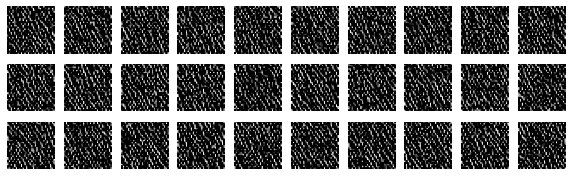

Train | Epoch: 10 [0/60160]		D-Loss: 0.685454	G-Loss: 1.108349
Train | Epoch: 10 [12800/60160]		D-Loss: 0.666323	G-Loss: 1.115980
Train | Epoch: 10 [25600/60160]		D-Loss: 0.656515	G-Loss: 1.133281
Train | Epoch: 10 [38400/60160]		D-Loss: 0.641544	G-Loss: 1.145047
Train | Epoch: 10 [51200/60160]		D-Loss: 0.639219	G-Loss: 1.160299

====> Train | Epoch: 10 	 | 	Average D-loss: 0.6576 	 | 	Average G-loss: 1.1329
====> Test | Average D-loss: 0.6120 	 | 	Average G-loss: 1.1374


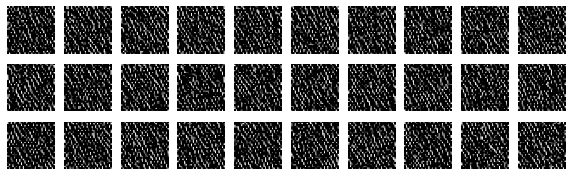

In [50]:
#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=20, G_update_times=1, D_update_times=1, verbose=True)
####################### End ########################

### 4.4.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 16 to 19)

In [0]:
mnist_visulization_helper_fn(mnist_trainer)
show_interpolations(mnist_trainer, 10, 10)